## 1. Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 64

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

print(ROOT_PATH)

/home/aiffel/aiffel


## 2. 데이터 준비

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames)) # val 데이터셋의 수가 너무 적다.

5216
624
16


In [4]:
#  train : val를 80:20으로 분할

filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# train 데이터 안의 정상 이미지 수와 폐렴 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [6]:
# tf.data 인스턴스 만들기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨 이름 확인

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
# 라벨 데이터를 만들어 주는 함수 만들기

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
#  이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경

def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 만들기

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 및 라벨 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 셋 만들기
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# augmentation 추가

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

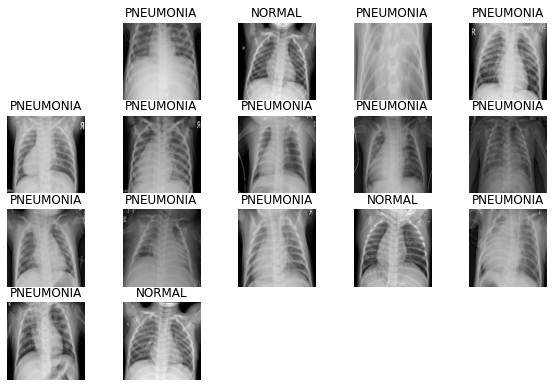

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(6,5,n+2)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [16]:
# conv_block 만들기

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
# dense_block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


## 6. 모델 훈련

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 39s 594ms/step - loss: 0.3992 - accuracy: 0.7974 - precision: 0.9542 - recall: 0.7634 - val_loss: 0.5708 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 34s 530ms/step - loss: 0.2012 - accuracy: 0.9224 - precision: 0.9792 - recall: 0.9146 - val_loss: 0.6698 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 36s 555ms/step - loss: 0.1573 - accuracy: 0.9411 - precision: 0.9801 - recall: 0.9398 - val_loss: 0.8286 - val_accuracy: 0.7451 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 34s 522ms/step - loss: 0.1523 - accuracy: 0.9481 - precision: 0.9819 - recall: 0.9475 - val_loss: 0.9469 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 34s 522ms/step - loss: 0.1412 - accuracy: 0.9478

65/65 [==============================] - 36s 552ms/step - loss: 0.0421 - accuracy: 0.9825 - precision: 0.9957 - recall: 0.9806 - val_loss: 0.1368 - val_accuracy: 0.9678 - val_precision: 0.9959 - val_recall: 0.9607
Epoch 38/50
65/65 [==============================] - 33s 515ms/step - loss: 0.0382 - accuracy: 0.9865 - precision: 0.9951 - recall: 0.9867 - val_loss: 0.0818 - val_accuracy: 0.9785 - val_precision: 0.9907 - val_recall: 0.9804
Epoch 39/50
65/65 [==============================] - 34s 529ms/step - loss: 0.0330 - accuracy: 0.9863 - precision: 0.9961 - recall: 0.9855 - val_loss: 0.2183 - val_accuracy: 0.9492 - val_precision: 1.0000 - val_recall: 0.9319
Epoch 40/50
65/65 [==============================] - 34s 519ms/step - loss: 0.0288 - accuracy: 0.9894 - precision: 0.9971 - recall: 0.9886 - val_loss: 0.2399 - val_accuracy: 0.9453 - val_precision: 0.9986 - val_recall: 0.9277
Epoch 41/50
65/65 [==============================] - 33s 509ms/step - loss: 0.0361 - accuracy: 0.9870 - prec

## 7. 결과 확인과 시각화

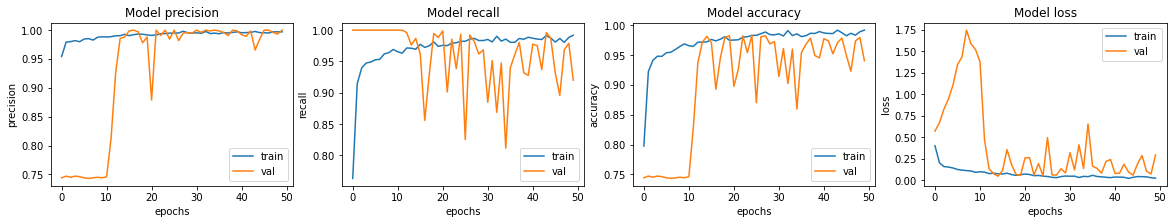

In [26]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

10/10 [==============================] - 23s 2s/step - loss: 0.5448 - accuracy: 0.8782 - precision: 0.8601 - recall: 0.9615
